# 15. Accessing Economic Data via APIs

## Introduction: The Power of Programmatic Data Access

In modern economic research, data is paramount. While manually downloading datasets from websites is feasible for small-scale projects, this approach quickly becomes inefficient, error-prone, and impossible to scale. The professional standard for acquiring up-to-date, reproducible data is through Application Programming Interfaces (APIs).

An API is a structured interface that allows computer programs to communicate with each other. Major data providers like the Federal Reserve and the World Bank offer APIs that give us direct, programmatic access to their vast databases. Using an API offers several distinct advantages:

1.  **Reproducibility:** Your data acquisition process is encoded in a script, making your research perfectly reproducible by others.
2.  **Efficiency:** You can automate the process of downloading, updating, and merging hundreds of data series with just a few lines of code.
3.  **Scale:** APIs allow you to query and retrieve datasets that are far too large to handle manually.
4.  **Real-Time Access:** You can build applications and dashboards that always have access to the very latest data releases.

This notebook provides a practical guide to using Python to access two of the most important data sources for economists:

*   **Federal Reserve Economic Data (FRED):** A comprehensive database of over 800,000 U.S. and international time series, maintained by the St. Louis Fed.
*   **World Bank Open Data:** A massive collection of global development indicators covering demographics, economics, finance, and more.

We will use dedicated Python libraries that act as "wrappers" for these APIs, making it simple to send requests and process the data.

## Part 1: The FRED API for U.S. and International Economic Data

The `fredapi` library provides a convenient Python wrapper for the FRED API.

### Getting Started: Installation and API Key

First, you need to install the `fredapi` library. You also need a FRED API key. Requesting a key is a simple, free process.

1.  Go to the [FRED API Keys page](https://fred.stlouisfed.org/docs/api/api_key.html).
2.  Sign in or create an account.
3.  Request an API key. It will be a 32-character alphanumeric string.

In [1]:
%pip install fredapi


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
from fredapi import Fred
from IPython.display import display

# Replace 'YOUR_API_KEY' with the key you obtained from the FRED website.
api_key = 'YOUR_API_KEY_HERE'

fred = None
# This check ensures the user has replaced the placeholder key.
if api_key != 'YOUR_API_KEY_HERE' and api_key != '':
    try:
        fred = Fred(api_key=api_key)
        print("Successfully connected to FRED API.")
    except Exception as e:
        print(f"Error connecting to FRED. Please check your API key. Details: {e}")
else:
    print("FRED API key not provided. The FRED-related cells will be skipped.")

FRED API key not provided. The FRED-related cells will be skipped.


### Searching for Data

The most challenging part of using a large database is often finding the specific series you need. The `fred.search()` method is an invaluable tool for this. It returns a DataFrame of series that match your search query, along with their IDs, which you need for downloading.

In [3]:
# Let's search for series related to the Consumer Price Index (CPI)
if fred:
    cpi_results = fred.search('Consumer Price Index')

    # The search results can be quite large, so let's inspect the first 10 rows.
    display(cpi_results.head(10))
else:
    print("Skipping FRED search as API key was not provided.")

Skipping FRED search as API key was not provided.


### Downloading and Plotting a Single Series

Once you have the ID of a series (e.g., 'CPIAUCSL' for the Consumer Price Index for All Urban Consumers), you can download it directly into a pandas Series or DataFrame using `get_series()`.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

cpi_data = None
if fred:
    # Download the seasonally adjusted CPI data
    cpi_series_id = 'CPIAUCSL'
    cpi_data = fred.get_series(cpi_series_id)

    # Let's look at the most recent data
    print(cpi_data.tail())

    # Plot the data
    plt.figure(figsize=(12, 6))
    cpi_data.plot(title='Consumer Price Index (CPIAUCSL)', grid=True)
    plt.ylabel('Index 1982-1984=100')
    plt.show()
else:
    print("Skipping FRED data download as API key was not provided.")

Skipping FRED data download as API key was not provided.


### Practical Example: The Phillips Curve

Let's recreate a classic macroeconomic relationship: the Phillips Curve, which shows a historical inverse relationship between unemployment and inflation. We need to download two series: the unemployment rate ('UNRATE') and an inflation measure. We'll calculate inflation as the year-over-year percentage change in the CPI.

In [5]:
# This cell depends on the previous one, so we check both fred and cpi_data
if fred and cpi_data is not None:
    # Download the civilian unemployment rate
    unemployment_data = fred.get_series('UNRATE')

    # Calculate year-over-year inflation from the CPI data we already have
    inflation_data = cpi_data.pct_change(12).dropna() # dropna() removes the first 12 months with no value

    # To plot them together, we need to align the data. We'll create a DataFrame.
    phillips_df = pd.DataFrame({
        'Unemployment': unemployment_data,
        'Inflation_YoY': inflation_data
    }).dropna()

    # Let's look at data from 2000 onwards
    phillips_df_recent = phillips_df.loc['2000-01-01':]

    # Create a scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(phillips_df_recent['Unemployment'], phillips_df_recent['Inflation_YoY'])
    plt.title('The Phillips Curve (2000-Present)')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('Year-over-Year Inflation (%)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping Phillips Curve example as API key was not provided.")

Skipping Phillips Curve example as API key was not provided.


## Part 2: The World Bank API for Global Development Data

For cross-country analysis, the World Bank is an indispensable resource. The `wbdata` library provides a straightforward interface to its API.

In [6]:
%pip install wbdata


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [7]:
import wbdata

### Searching for Indicators and Countries

Similar to FRED, the first step is finding the indicators and country codes you need. `wbdata` provides search functions for this.

In [8]:
# Search for indicators related to GDP per capita
gdp_indicators = wbdata.get_indicators(query='gdp per capita')
gdp_indicators

id                          name
--------------------------  ----------------------------------------------------------------------------------------------------------
6.0.GDPpc_constant          GDP per capita, PPP (constant 2011 international $)
CC.GHG.MEMG.GC              Macro drivers of GHG emissions growth in the period 2012-2018 - GDP per capita
FB.DPT.INSU.PC.ZS           Deposit insurance coverage (% of GDP per capita)
NV.AGR.PCAP.KD.ZG           Real agricultural GDP per capita growth rate (%)
NY.GDP.PCAP.CD              GDP per capita (current US$)
NY.GDP.PCAP.CN              GDP per capita (current LCU)
NY.GDP.PCAP.KD              GDP per capita (constant 2015 US$)
NY.GDP.PCAP.KD.ZG           GDP per capita growth (annual %)
NY.GDP.PCAP.KN              GDP per capita (constant LCU)
NY.GDP.PCAP.PP.CD           GDP per capita, PPP (current international $)
NY.GDP.PCAP.PP.KD           GDP per capita, PPP (constant 2021 international $)
NY.GDP.PCAP.PP.KD.87        GDP per capit

### Downloading Data for Multiple Countries

The real power here is downloading data for the same indicator across many countries simultaneously. The `wbdata.get_dataframe()` function is perfect for this. It requires a dictionary of indicator IDs and a list of country codes.

Let's compare GDP per capita (constant 2015 USD) for the BRICS countries (Brazil, Russia, India, China, South Africa).

In [9]:
import datetime

# Define indicators and countries
# We'll use 'NY.GDP.PCAP.KD' for GDP per capita (constant 2015 US$)
indicators = {'NY.GDP.PCAP.KD': 'GDP per Capita'}
countries = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF'] # BRICS countries

# Define the time range
start_date = datetime.datetime(1990, 1, 1)
end_date = datetime.datetime(2022, 1, 1)

# Download the data
gdp_data = wbdata.get_dataframe(indicators, country=countries, date=(start_date, end_date))

gdp_data.head()

GDP per Capita
country date                
Brazil  2022     9032.084816
        2021     8799.229458
        2020     8435.011433
        2019     8771.440513
        2018     8722.336303

### Cleaning and Plotting the Data

The data from `wbdata` often comes in a "wide" format, with countries as columns. For plotting with many libraries, we need to transform it into a "long" format. The `.unstack()` method is a powerful tool for this.

        GDP per Capita                                              \
country         Brazil        China       India Russian Federation   
date                                                                 
1990       6149.867889   917.270662  537.870270        7849.519043   
1991       6107.648837   989.548541  531.898398        7432.021484   
1992       5973.982856  1117.273295  549.235070        6345.912109   
1993       6167.460922  1258.349461  563.372872        5798.914551   
1994       6427.169019  1406.858457  588.727892        5071.742676   

                      
country South Africa  
date                  
1990     4544.230232  
1991     4396.360695  
1992     4225.814328  
1993     4193.598261  
1994     4258.261847  


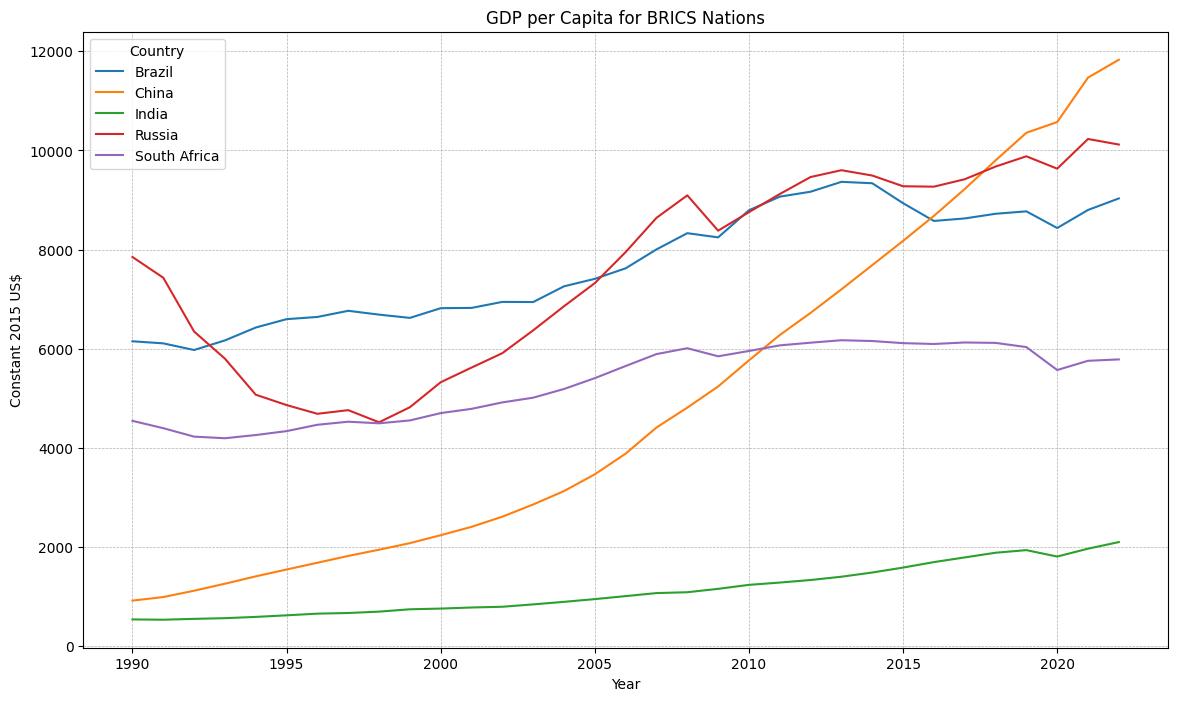

In [10]:
# The DataFrame has a MultiIndex (country, date). Let's unstack it.
gdp_unstacked = gdp_data.unstack(level=0)

# Let's look at the result
print(gdp_unstacked.head())

# Now we can plot it
plt.figure(figsize=(14, 8))
gdp_unstacked.plot(ax=plt.gca())
plt.title('GDP per Capita for BRICS Nations')
plt.ylabel('Constant 2015 US$')
plt.xlabel('Year')
plt.legend(title='Country', labels=['Brazil', 'China', 'India', 'Russia', 'South Africa'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Conclusion

In this notebook, you have learned the fundamentals of programmatic data access using Python. You are now equipped to:

- Install and use the `fredapi` and `wbdata` libraries.
- Search for specific data series and indicators within these vast databases.
- Download and visualize data for single and multiple series/countries.
- Perform basic data manipulation to prepare API data for analysis.

These skills are foundational for modern, reproducible economic research. They allow you to move beyond static CSV files and build dynamic, scalable, and robust data analysis pipelines.